# 제품(wine) review 데이터의 감성 분석

#### 감성분석 : 대량의 텍스트를 분석하여 해당 내용의 긍정/부정/중립적인 감정을 판단하는 분석, 자연어 처리(NLP)와 머신러닝(ML)기술을 활용함.

# 1. 데이터 전처리

### 1.1 데이터 정리 

In [26]:
#CSV파일 불러오기
import pandas as pd

df = pd.read_csv('./wine_review.csv')

In [27]:
#wine_review csv 파일의 행과 열 개수 확인 - 결측치 처리와 관련됨
print("The shape of the data (rows, cols) is " + str(df.shape))

The shape of the data (rows, cols) is (2890, 32)


In [28]:
#결측치가 있는 열 확인
df.isnull().sum()

id                         0
asins                   2020
brand                     65
categories                 0
dateAdded                  0
dateUpdated                0
descriptions             152
dimension               1052
ean                      724
flavors                 2739
keys                       0
manufacturer            2041
manufacturerNumber       433
name                       0
reviews.date             338
reviews.dateAdded          0
reviews.dateSeen           0
reviews.didPurchase      841
reviews.doRecommend      979
reviews.id              1005
reviews.numHelpful      2264
reviews.rating           445
reviews.sourceURLs         0
reviews.text               1
reviews.title             44
reviews.userCity        2808
reviews.userProvince    2881
reviews.username           2
sizes                   2868
sourceURLs                 0
upc                      147
weight                  1894
dtype: int64

In [29]:
#사용할 열 - 'name', 'reviews.rating', reviews.text' 추출
df =  df[['name', 'reviews.rating','reviews.text']]

In [30]:
#'name', 'reviews.rating', 'revies.text' 열의, 분석에 방해가 되는 결측치가 있는 행 제거
df = df.dropna(axis=0)
print(df.isnull().sum())
print("The shape of the data (rows, cols) is " + str(df.shape))

#총 2444개의 데이터로 감정 분석 진행

name              0
reviews.rating    0
reviews.text      0
dtype: int64
The shape of the data (rows, cols) is (2444, 3)


In [31]:
#데이터 프레임 확인
df.head()

,name,reviews.rating,reviews.text
0,Ecco Domani174 Pinot Grigio - 750ml Bottle,5.0,This a fantastic white wine for any occasion!
1,Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle,5.0,"Tart, not sweet...very refreshing and delicious!"
2,1000 Stories174 Zinfandel - 750ml Bottle,5.0,I was given this wine so it was a delightful s...
3,1000 Stories174 Zinfandel - 750ml Bottle,5.0,This is a phenomenal wine and my new favorite ...
4,Pink Moscato - 3l Bottle - Wine Cube153,5.0,4 750ml bottles for the price of two With way ...


### 1.2 텍스트 토큰화 및 불용어 제거

In [32]:
# 텍스트 전처리 및 감정분석에 필요한 nltk 라이브러리 설치
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [33]:
#필요한 라이브러리 import
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [34]:
#불용어 등 감정분석에 필요한 nltk 내장 자료 다운로드
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [35]:
#텍스트 토큰화 
def tokenize_reviews(text):
    return word_tokenize(text)

#불용어 제거
def remove_stopwords(text):
    stop_words = set(stopwords.words('english')) #다운로드 받은 NLTK의 불용어 리스트를 사용
    filtered_tokens = [word for word in text if word.lower() not in stop_words] #소문자로 변환하여 불용어를 제거
    return filtered_tokens

### 1.3 텍스트 정규화

In [36]:
#텍스트 스테밍(단어의 어간 추출)
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(tag)) for word, tag in pos_tags]
    return lemmatized_tokens


#표제어 추출
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def stem(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word.lower()) for word in tokens]  # 단어의 어간 추출
    return stemmed_tokens    

# 2. 모델 구현

In [37]:
#감성 분석 - reviews.text의 내용을 통해 감성을 분석하여 점수로 반환한다.
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores

In [38]:
#텍스트 토큰화 -> 불용어 제거 -> 어간 추출 -> 표제어 추출 순서대로 전처리 된 내용을 새로운 열에 저장함.
df['tokenized_text'] = df['reviews.text'].apply(tokenize_reviews)
df['filtered_text'] = df['tokenized_text'].apply(remove_stopwords)
df['stemmed_text'] = df['filtered_text'].apply(stem)
df['lemmatized_text'] = df['filtered_text'].apply(lemmatize)
df['sentiment'] = df['lemmatized_text'].apply(lambda x: analyze_sentiment(' '.join(x)))

In [39]:
#최종 어간 추출되고 표제어 추출된 결과 출력
print(df[['stemmed_text', 'lemmatized_text']])

                                           stemmed_text  \
0                      [fantast, white, wine, occas, !]   
1             [tart, ,, sweet, ..., refresh, delici, !]   
2     [given, wine, delight, surpris, find, flavor, ...   
3                [phenomen, wine, new, favorit, red, .]   
4     [4, 750ml, bottl, price, two, way, less, packa...   
...                                                 ...   
2885  [like, sweet, wine, ., skeptic, order, without...   
2886  [order, 3, bottl, set, meritag, &, moscata, wi...   
2887  [order, white, zinfadel, 3, bottl, select, arr...   
2888  [first, purchas, wine, ., tri, moscato, like, ...   
2889  [n't, know, neg, review, said, wine, tast, hor...   

                                        lemmatized_text  
0                 [fantastic, white, wine, occasion, !]  
1          [tart, ,, sweet, ..., refresh, delicious, !]  
2     [give, wine, delightful, surprise, find, flavo...  
3             [phenomenal, wine, new, favorite, red, .]  
4

In [40]:
#데이터 프레임을 통해 데이터가 변화된 과정 확인
df.head()

,name,reviews.rating,reviews.text,tokenized_text,filtered_text,stemmed_text,lemmatized_text,sentiment
0,Ecco Domani174 Pinot Grigio - 750ml Bottle,5.0,This a fantastic white wine for any occasion!,"[This, a, fantastic, white, wine, for, any, oc...","[fantastic, white, wine, occasion, !]","[fantast, white, wine, occas, !]","[fantastic, white, wine, occasion, !]","{'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'comp..."
1,Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle,5.0,"Tart, not sweet...very refreshing and delicious!","[Tart, ,, not, sweet, ..., very, refreshing, a...","[Tart, ,, sweet, ..., refreshing, delicious, !]","[tart, ,, sweet, ..., refresh, delici, !]","[tart, ,, sweet, ..., refresh, delicious, !]","{'neg': 0.0, 'neu': 0.3, 'pos': 0.7, 'compound..."
2,1000 Stories174 Zinfandel - 750ml Bottle,5.0,I was given this wine so it was a delightful s...,"[I, was, given, this, wine, so, it, was, a, de...","[given, wine, delightful, surprise, find, flav...","[given, wine, delight, surpris, find, flavor, ...","[give, wine, delightful, surprise, find, flavo...","{'neg': 0.0, 'neu': 0.304, 'pos': 0.696, 'comp..."
3,1000 Stories174 Zinfandel - 750ml Bottle,5.0,This is a phenomenal wine and my new favorite ...,"[This, is, a, phenomenal, wine, and, my, new, ...","[phenomenal, wine, new, favorite, red, .]","[phenomen, wine, new, favorit, red, .]","[phenomenal, wine, new, favorite, red, .]","{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'comp..."
4,Pink Moscato - 3l Bottle - Wine Cube153,5.0,4 750ml bottles for the price of two With way ...,"[4, 750ml, bottles, for, the, price, of, two, ...","[4, 750ml, bottles, price, two, way, less, pac...","[4, 750ml, bottl, price, two, way, less, packa...","[4, 750ml, bottle, price, two, way, le, packag...","{'neg': 0.09, 'neu': 0.553, 'pos': 0.357, 'com..."


In [41]:
#텍스트의 전체적인 감성을 나타내는 값인 compound를 0.05기준으로 정함.
#0.05 이상은 긍정인 1으로 나타내며, 0.05 미만은 부정으로 0으로 반환함.

def sentiment_label(sentiment_scores):
    if sentiment_scores['compound'] >= 0.05:
        return 1
    else:
        return 0

df['sentiment_label'] = df['sentiment'].apply(sentiment_label)

# 3. 모델 학습 및 튜닝

### 3.1 데이터셋 분할

In [42]:
#모델 학습에 필요한 라이브러리 호출
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix

In [43]:
#입력 데이터 'x'와 레이블 'y'설정
X = df['reviews.text']
y = df['sentiment_label']

#학습데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2 모델학습 및 하이퍼파라미터 튜닝, 교차검증

In [44]:
#긍정/부정이라는 두 가지 감정을 이진분류로 파악할 수 있는 로지스틱 회귀분석을 사용하고자 함.
#로지스틱 회귀 분류 모델을 사용하기 전 TF-IDF 벡터화를 위한 파이프라인
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear', multi_class='ovr'))
])

# 하이퍼파라미터 그리드 정의
param_grid = {
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1, 1, 10]
}

# 그리드 서치
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1) #5-fold 교차 검증 적용

# 그리드 서치 수행
grid_search.fit(X_train, y_train) #최적의 하이퍼파라미터를 찾아 모델을 학습시킴

#결과
#max_df = 0.8 : 문서에서 80% 이상 나타나는 즉, 빈도가 높은 단어는 TF-IDF 벡터화에서 무시함.
#libliner : 회귀모델 최적화에 사용되는 알고리즘으로 libliner 알고리즘 사용함.

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logreg',
                                        LogisticRegression(multi_class='ovr',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.1, 1, 10],
                         'tfidf__max_df': [0.8, 0.9, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [45]:
#앞서 정의된 그리드 서치를 통해 모델을 학습함. 
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Best parameters found:  {'logreg__C': 10, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 1)}


# 4. 모델 평가

### 4.1 모델 평가

In [46]:
# 정확도, 정밀도, 재현율, F1 점수를 통한 모델 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#학습 데이터 평가 결과
#1) 정확도(accuracy)는 0.8957로 89.57%의 정확도로 예측할 수 있다.
#2) class 0에서는 비교적 낮은 재현율과 낮은 f1점수를 가지고 있다. 
#3) class 1에서는 높은 정밀도와 재현율, fq점수를 가지고 있다.
#4) 즉, 긍정적인 반응(class 1)에 대해서는 잘 예측하고 있으나, 부정적인 반응(class 2)에 대해서는 모델 개선이 필요하다.

Accuracy: 0.8957055214723927
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.48      0.59        77
           1       0.91      0.97      0.94       412

    accuracy                           0.90       489
   macro avg       0.84      0.73      0.77       489
weighted avg       0.89      0.90      0.89       489



### 4.2 오버피팅과 해결방안

In [47]:
#평가 결과를 통해 모델이 class 1을 주로 학습하는, 훈련 데이터에 너무 맞추어져 있기에 오버피팅을 의심해 볼 수 있다.
#이를 해결하기 위해 로지스틱 회귀의 c값을 작게 설정하여 일반화할 수 있도록 조정함. 

param_grid = {
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.01, 0.1, 5]  #c값을 10에서 5로 재설정
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic

Best parameters found:  {'logreg__C': 5, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 1)}


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [48]:
#결과 출력
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#오버피팅 조정 결과
#1)class 0에 대한 정밀도가 증가했으나, 재현율과 F1-score은 감소함.
#2)이는 클래스 0을 더 적게 예측하고 예측하더라도 정확하지 않는다는 것을 의미한다.
#3)오버피팅을 해결하는 방안은 
#부정적 반응에 대한 데이터의 수를 늘리거나(기존의 결측치가 있는 값을 제거하지 않는 방법) 
#사용한 방법과 같이 로지스틱 회귀 값의 강도를 의미하는 c값을 줄인다.
#마지막으로 regulaization이라는 모델의 계수를 0에 가깝게 하여 계수의 절대값을 줄이는 방안(Ridge, Lasso)을 사용한다.

Accuracy: 0.8957055214723927
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.36      0.52        77
           1       0.89      1.00      0.94       412

    accuracy                           0.90       489
   macro avg       0.91      0.68      0.73       489
weighted avg       0.90      0.90      0.88       489



# 5. 시각화 및 보고

### 5.1 결과 시각화

In [49]:
#시각화를 위한 Matplotlib과 Seaborn 라이브러리 호출
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [50]:
#로지스틱 회귀 모델에서 사용된 단어들의 계수를 통한 긍정적, 부정적 단어 추출 시각화 과정
feature_names = best_model.named_steps['tfidf'].get_feature_names_out() #TF-IDF 벡터화에서 추출된 단어를 가져온다.
coefficients = best_model.named_steps['logreg'].coef_[0] #로지스틱 회귀 모델의 계수를 가져온다. 

#긍정적 감정에 기여하는 상위 10개 단어와 부정적 감정에 기여하는 상위 10개 단어 추출
top_positive_coefficients = np.argsort(coefficients)[-10:] #계수가 가장 큰 10개의 단어 추출
top_negative_coefficients = np.argsort(coefficients)[:10] #계수가 가장 작은 10개의 단어 추출

#단어와 점수(계수)저장
pos_top_word = []
pos_top_score = []
for coef in top_positive_coefficients:
    pos_top_word.append(feature_names[coef]) #단어를 리스트에 추가
    pos_top_score.append(coefficients[coef]) #계수를 리스트에 추가

neg_top_word = []
neg_top_score = []
for coef in top_negative_coefficients:
    neg_top_word.append(feature_names[coef]) #단어를 리스트에 추가
    neg_top_score.append(coefficients[coef]) #계수를 리스트에 추가

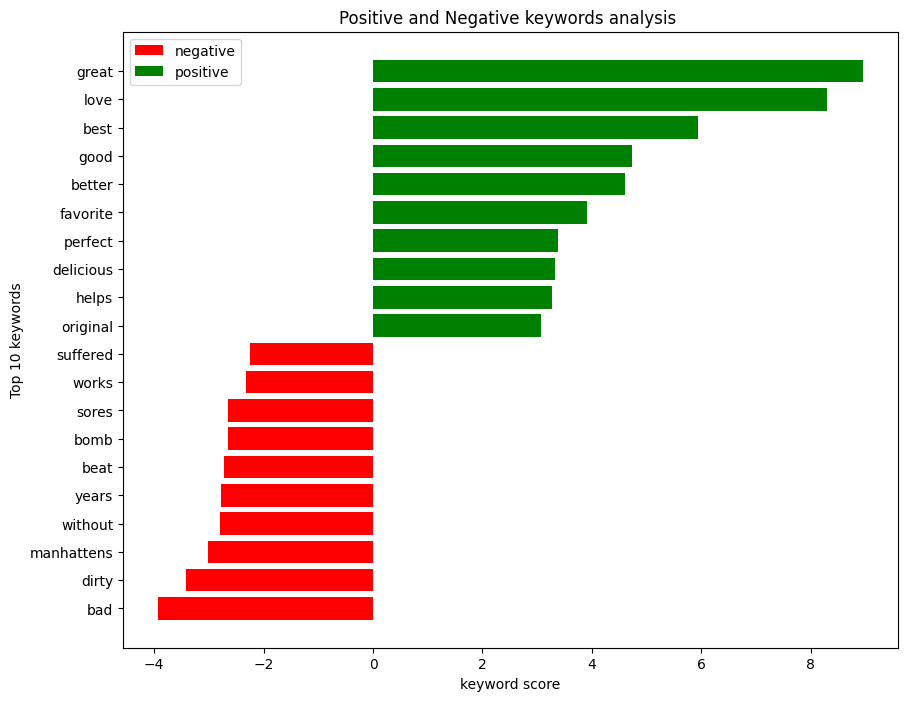

In [51]:
# 시각화
plt.figure(figsize=(10, 8))
plt.barh(neg_top_word, neg_top_score, label='negative', color='r')
plt.barh(pos_top_word, pos_top_score, label='positive', color='g')
plt.legend()
plt.xlabel('keyword score')
plt.ylabel('Top 10 keywords')
plt.title('Positive and Negative keywords analysis ')
plt.show()


### 5.2 혼동 행렬

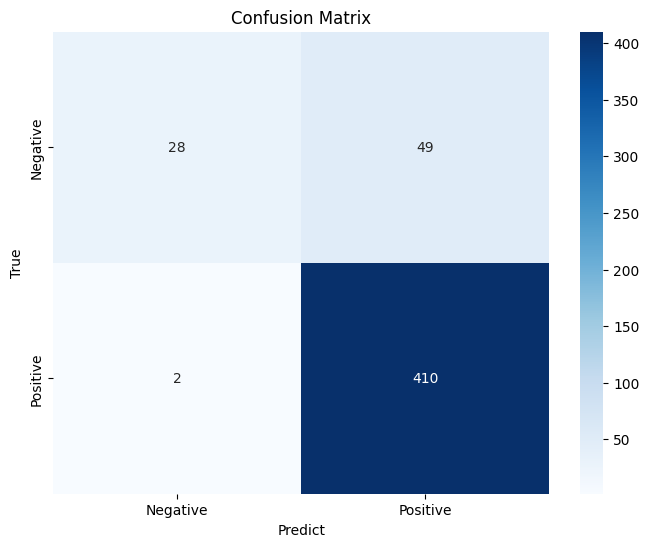

In [52]:
#혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 5.3 결과 분석

- 긍정적 키워드는 'great', 'love', 'best', 'good', 'better'등의 표현을 사용하는 것을 알 수 있다.
- 부정적 키워드로는 'bad'가 가장 높았다. 부정적인 반응을 나타내는 키워드(형용사)는 긍정적인 반응에 대한 키워드 보다 적다.
- 주목해야할 부정적 키워드 중 'dirty'는 단어 그대로 '더러운'이라는 뜻이 아닌, 실제 리뷰를 살펴본 결과 주로 'dirty martini'의 'dirty'를 지칭하는 것으로 나타남. 'dirt martini'는 칵테일의 한 종류이다. 
- 긍정적인 반응임에도 불구하고 'dirty'라는 키워드가 나온 것을 통해, 고유 명사에 나오는 단어를 해결하지 못하여 부정적인 반응에 대한 예측이 정확하지 않다는 가능성 또한 알 수 있다. 

- 혼동 행렬 결과 positive 모델을 실제로 positive로 예측한 결과가 410으로 가장 높게 나왔다. 
- 이는 positive, 긍정적인 반응에 대한 예측은 정확히 할 수 있다는 것을 의미한다.
- 가장 낮은 횟수인 상단 왼쪽의 모델이 Negative를 올바르게 예측한 경우, 즉 부정적 반응에 대해 부정적인 반응이라고 예측한 결과는 28으로 매우 낮게 나왔다.
- 따라서, 해당 모델은 positive 클래스에 편향되었다고 볼 수 있다. 이를 해결하기 위해 앞서 설명한 것과 같이 부정적인 사례에 대한 데이터를 추가하거나 오버피팅을 해결하여야 한다.